# Categorisez automatiquement des questions - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [Monogram](#Monogram)
    * [BAG OF WORDS](#BAG-OF-WORDS)
    * [TF-IDF](#TF-IDF)
        * [Bodies](#Bodies)
        * [Titles](#Titles)
        * [Pondere](#Pondere)
        * [Bodies+titles](#Bodies+titles)
    * [REDUCTION DIMENSIONNELLE - ACP](#REDUCTION-DIMENSIONNELLE---ACP)
    * [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
*[Tags](#Tags)
    * [Classement-TF-IDF](#Tags)
    * [Labellisation](#Labellisation)

# PREPARATION

## Import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import r2_score, accuracy_score

from sklearn.manifold import TSNE

from collections import Counter

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return -1
    else:
        tags=row.idxmax().split() #separation du bigramme
        print(tags)
        rowclass=tagclass.get(tags[0],-1)
        if rowclass<0:
            print('row negative')
            rowclass=tagclass.get(tags[1],-1)
        return rowclass

# CHARGEMENT

In [6]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [7]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 43576 to 48725
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        2000 non-null   object
 1   Body         2000 non-null   object
 2   Tags         2000 non-null   object
 3   BodyLemmas   2000 non-null   object
 4   TitleLemmas  2000 non-null   object
dtypes: object(5)
memory usage: 93.8+ KB


In [8]:
dfCleaned.sample(8)

,Title,Body,Tags,BodyLemmas,TitleLemmas
16888,how to hide the first row of my recycler view?,"<p>i want to know how i can hide the specified row in my recycler-row-layout. i specified my row in a seperate layout and it will show as the first row. \nthanks alot, ill rate your comments. sry ...",android android-recyclerview,"[want, know, hide, specify, row, recycler, row, layout, specify, row, seperate, layout, show, first, row, thanks, alot, ill, rate, comment, sry, language]","[hide, first, row, recycler, view]"
39516,parse image to byte array and send to web service,<p>i am wondering how i can get an image from a silverlight image control and parse it to a byte array so i can send it to my web service. thanks for your help.</p>\n,silverlight image parsing bytearray bitmapimage,"[wonder, get, image, silverlight, image, control, parse, byte, array, send, web, service, thanks, help]","[parse, image, byte, array, send, web, service]"
9124,cordova in ios blank white screen,"<p>i am using cordova in ios. all my html pages are loading fine.but, sometimes i am getting white blank screen instead of the content.how to resolve it?</p>\n",cordova,"[use, cordova, io, html, page, lo, fine, sometimes, get, white, blank, screen, inste, content, resolve]","[cordova, io, blank, white, screen]"
29637,adjust width of input field to its input,"<pre><code>&lt;html&gt;\n &lt;head&gt;\n &lt;/head&gt;\n &lt;body&gt;\n &lt;input type=""text"" value=""1"" style=""min-width:1px;"" /&gt;\n &lt;/body&gt;\n&lt;/html&gt;\n</code></pre>\n\n<p>this...",javascript html css,"[html, body, input, type, text, value, style, min, width, body, html, code, work, way, html, javascript, php, cs, set, minimum, width, want, text, input, field, dynami, change, width, input, field...","[adjust, width, input, field, input]"
17626,how to use javax.validation with thymeleaf,"<p>when i run this it will create a new book if valid however upon error it will not post back to the page and i get a 400:</p>\n\n<pre><code>this application has no explicit mapping for /error, s...",validation thymeleaf,"[run, create, new, book, valid, however, upon, error, post, page, get, appli, explicit, mapping, error, see, fall, unexpected, error, type, request, status, vali, fail, object, book, error, count,...","[use, javax, validation, thymeleaf]"
25944,how to make log4j to write to the console as well,"<p>is there any way to tell to log4j to write its log to the file and to the console?\nthanks\nthere are my properties:</p>\n\n<pre><code>log4j.rootlogger=debug,console,r\nlog4j.rootlogger=info, f...",java apache logging log4j,"[way, tell, log, write, log, file, console, thanks, property, log, rootlogger, debug, console, log, rootlogger, info, file, log, appender, console, org, ap, log, consoleappender, log, appender, co...","[make, log4j, write, console, well]"
4715,host-device communication in terms of subnet mask and routing,"<p>let's say i have host computer with two ethernet adapters:</p>\n\n<ol>\n<li><p>lan adapter - connected to lan, obtains ip address automatically.</p></li>\n<li><p>device adapter - with ip addres...",sockets networking tcp mask subnet,"[let, say, host, computer, two, ethernet, lan, connect, lan, obtains, ip, automati, device, ip, subnet, mask, also, hardware, device, connect, device, work, like, tcp, ip, server, configure, ip, s...","[host, device, communication, term, subnet, mask, rout]"
39703,how to save datetime in edb database,"<p>i want to save datetime into the edb database. i tried storing the value by converting ctime to cstring. but after reading not able to convert cstring to ctime. ask the same <a href=""https://st...",datetime mfc windows-ce,"[want, save, try, store, value, convert, ctime, cstring, convert, cstring, ctime, ask, href, http, st, com, question, convert, cstring, ctime, question, st, yet, response, href, http, msdn, micros...","[save, datetime, edb, database]"


In [9]:
bodies=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)

# Pour tenir compte des titres, on les concatene aux corps de message
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']
bodies_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

# BAG OF WORDS

In [10]:
dfBowBodies=bow(bodies)
nBowBodies=dfBowBodies.to_numpy() # optimisation des calculs en passant par numpy

dfBowTitles=bow(titles)
nBowTitles=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [11]:
%%time
dfSumBowBodies=pd.DataFrame(data=nBowBodies.sum(axis=0))
dfSumBowBodies.index=dfBowBodies.columns
dfSumBowBodies.columns=['count']

dfSumBowTitles=pd.DataFrame(data=nBowTitles.sum(axis=0))
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitlesHead=dfSumBowTitles.sort_values(by='count',ascending=False).head(25)
dfSumBowBodiesHead=dfSumBowBodies.sort_values(by='count',ascending=False).head(25)

CPU times: user 45.6 ms, sys: 21 ms, total: 66.6 ms
Wall time: 65 ms


In [12]:
from IPython.display import display_html 


df1_styler = dfSumBowTitlesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowTitlesHead')
df2_styler = dfSumBowBodiesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowBodiesHead')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

,count
use,202
file,122
get,99
error,85
value,73
work,68
array,65
string,64
android,61
data,59


# Monogram

## TF-IDF

In [13]:
# Initialisation du vectoriseur TF IDF de scikit learn
vectorizer= TfidfVectorizer()

### Bodies

In [14]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies classement des mots')]

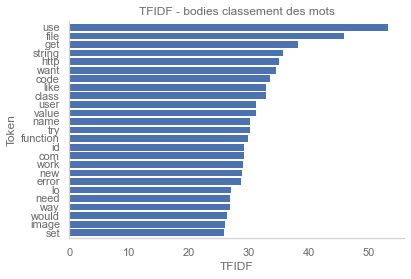

In [15]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies classement des mots')

### Titles

In [16]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 109 ms, sys: 14 ms, total: 123 ms
Wall time: 56.1 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - titles - classement des mots')]

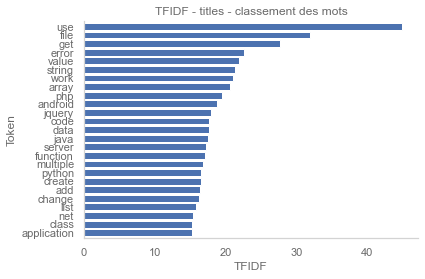

In [17]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - titles - classement des mots')

In [18]:
dfTFIDF_titles.shape,dfTFIDF_bodies.shape

((2000, 3044), (2000, 14975))

### Pondere

TF-IDF (Pondéré) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

In [19]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [20]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, detail to dimensional
dtypes: float64(2296)
memory usage: 35.0 MB


<AxesSubplot:>

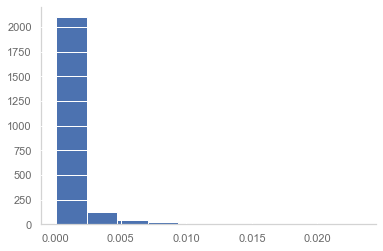

In [21]:
dfTFIDFCommon.mean(axis=0).hist()

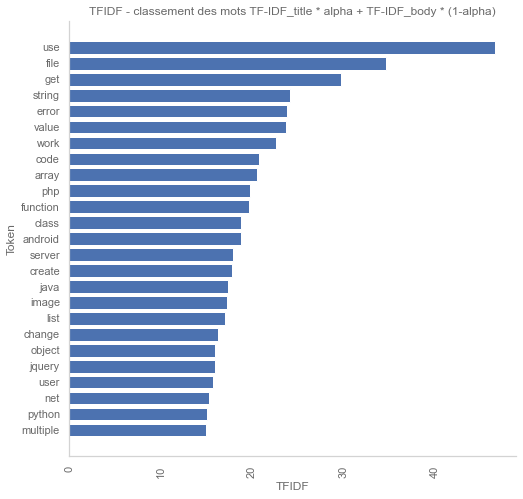

In [22]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [23]:
X=dfTFIDFCommon.values
X.shape

(2000, 2296)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


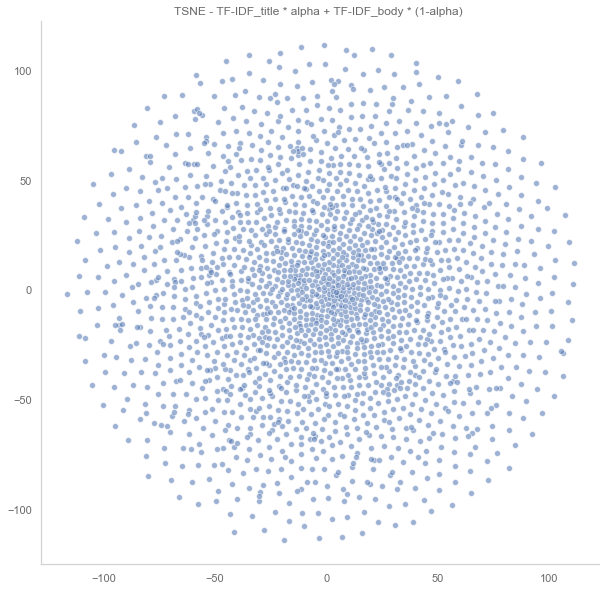

In [24]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) ')
plt.show()

### Bodies+titles

In [25]:
%%time
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 534 ms, sys: 95.8 ms, total: 630 ms
Wall time: 362 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies_titles - classement des mots')]

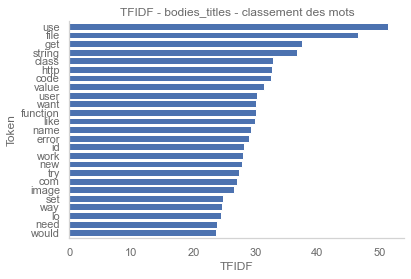

In [26]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies_titles - classement des mots')

Le calcul de TFIDF sur les corps et titres de message concaténés donne le même classement que pour le TFIDF sur les corps seuls.  
On preferera donc le TFIDF pondéré sur les titres et corps: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

In [27]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


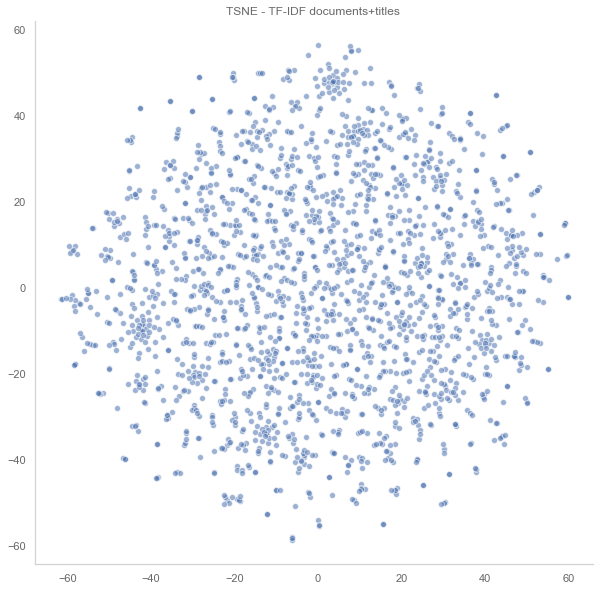

In [28]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

des regroupements semblent apparaitre sur la visualisation TSNE, voyons le score de silhouette/nombre de clusters obtenu par clustering K-Means

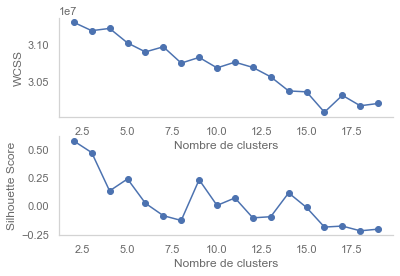

CPU times: user 9min 44s, sys: 8.71 s, total: 9min 53s
Wall time: 54.7 s


In [29]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le score de silhouette <0.25 au dela de 2 clusters.  
Le clustering KMeans n'est pas concluant pour les titres et corps de messages concaténés.

## REDUCTION DIMENSIONNELLE - ACP

<AxesSubplot:>

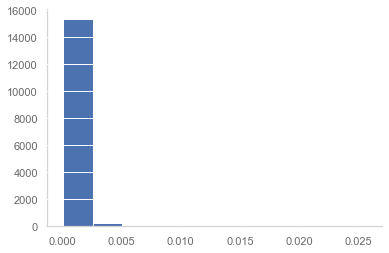

In [30]:
dfTFIDF_bodies_titles.mean(axis=0).hist()

La distribution des scores TFIDF est concentrée entre les valeurs 0 et 0.0025

In [31]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.01].fillna(0)
df.describe()

,detail,auto,lalr,decode,directive,breakpoint,sftp,xhr,component,elastic,mojo,reboot,mingw,envelope,submission,custom,webkit,game,website,spree,clob,share,webrequest,design,graphml,...,svn,controller,error,se,progress,zero,post,textbox,axios,roo,sudoku,bing,sas,sleep,throw,finger,role,zend,nsevent,developer,jetty,typescript,blueprint,fit,dimensional
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.000767,0.001386,0.000219,0.000419,0.000823,0.000279,0.000221,0.000259,0.002343,0.000460,0.000225,0.000184,0.000230,0.000231,0.000239,0.004909,0.000522,0.001337,0.002098,0.000297,0.000234,0.001879,0.000239,0.001644,0.000232,...,0.001204,0.001926,0.011459,0.000200,0.000648,0.001092,0.003298,0.001615,0.000215,0.000212,0.000180,0.000178,0.000318,0.000357,0.000659,0.000258,0.000713,0.001435,0.000288,0.000647,0.000474,0.000545,0.000265,0.000310,0.000860
std,0.011596,0.020379,0.009807,0.013075,0.019129,0.009548,0.009906,0.008803,0.026465,0.014577,0.010058,0.007828,0.009343,0.009233,0.009931,0.035634,0.014698,0.021219,0.023087,0.013271,0.009578,0.022098,0.010684,0.021663,0.010363,...,0.020691,0.024347,0.048446,0.005884,0.015242,0.019175,0.032658,0.024166,0.008504,0.008670,0.008035,0.007955,0.010116,0.011413,0.012223,0.008981,0.017560,0.024363,0.012902,0.010172,0.014993,0.014171,0.011848,0.010294,0.017883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.358947,0.447631,0.438584,0.489920,0.549004,0.420240,0.442997,0.384577,0.463865,0.489732,0.449796,0.349574,0.416626,0.409671,0.443465,0.404783,0.515379,0.521251,0.446308,0.593519,0.426393,0.388740,0.477819,0.392875,0.463430,...,0.424795,0.520779,0.483896,0.254256,0.522150,0.477545,0.

In [32]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, detail to dimensional
dtypes: float64(2296)
memory usage: 35.0 MB


(None,
 Index(['detail', 'auto', 'lalr', 'decode', 'directive', 'breakpoint', 'sftp',
        'xhr', 'component', 'elastic',
        ...
        'finger', 'role', 'zend', 'nsevent', 'developer', 'jetty', 'typescript',
        'blueprint', 'fit', 'dimensional'],
       dtype='object', length=2296))

In [33]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [34]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2296)

In [35]:
n_comp=1700 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=1700)

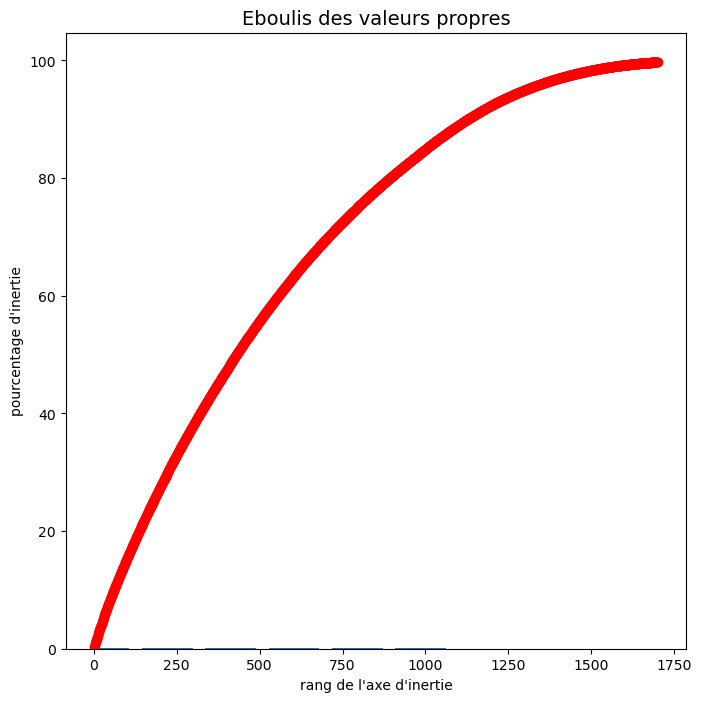

In [36]:
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [37]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [38]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 47.9 ms, sys: 10.8 ms, total: 58.7 ms
Wall time: 50.1 ms


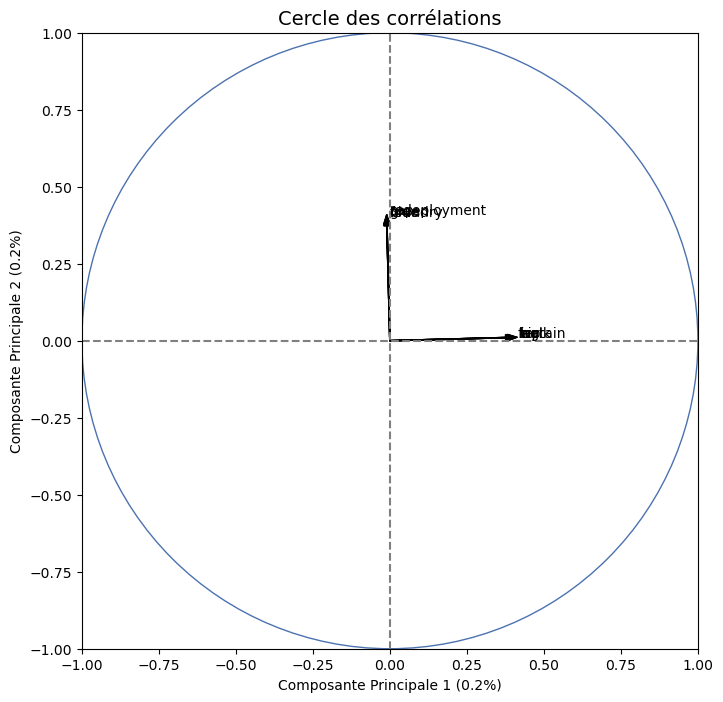

In [39]:
%%time
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.35:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [40]:
composantesPrincipales[d1]

array([-1.07192415e-03, -1.61107365e-03,  4.30606042e-04, ...,
       -2.38082624e-05, -6.51240399e-04,  1.24826295e-05])

In [41]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2296), (2296,), (2296,))

In [42]:
composantesPrincipales

array([[-1.07192415e-03, -1.61107365e-03,  4.30606042e-04, ...,
        -2.38082624e-05, -6.51240399e-04,  1.24826295e-05],
       [-1.45388933e-03, -2.63957543e-03, -1.04011679e-03, ...,
        -1.34065518e-03, -8.78340002e-04, -2.36435492e-03],
       [-1.63951232e-03, -2.44436244e-03, -1.41413369e-03, ...,
        -1.61636967e-03, -1.73264628e-03, -2.48175632e-03],
       ...,
       [-1.76927926e-02,  2.97577818e-02,  1.16587233e-02, ...,
         2.55415876e-03,  4.08633727e-02,  3.23269255e-02],
       [-1.15813713e-02,  2.41646982e-02, -1.50383177e-02, ...,
        -7.86455035e-03,  1.80500932e-02, -4.87258328e-02],
       [-1.36971731e-02,  2.04358474e-02, -7.08679020e-03, ...,
         2.59843717e-03,  6.68703441e-04, -1.63824105e-02]])

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


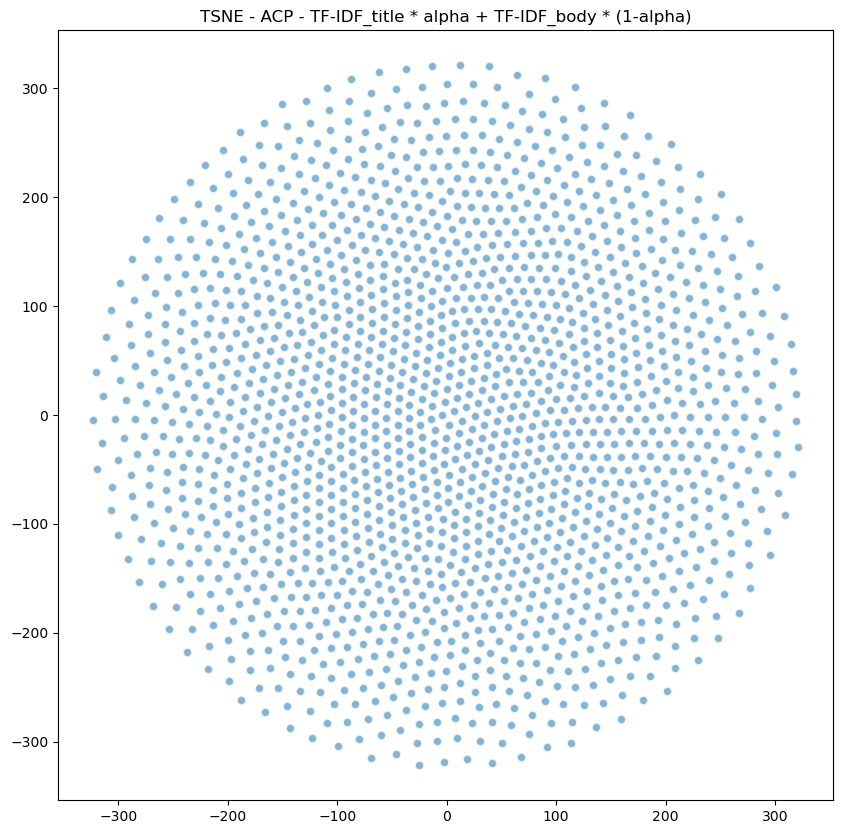

In [43]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

## CLUSTERING

In [44]:
X=df.values

### KMeans

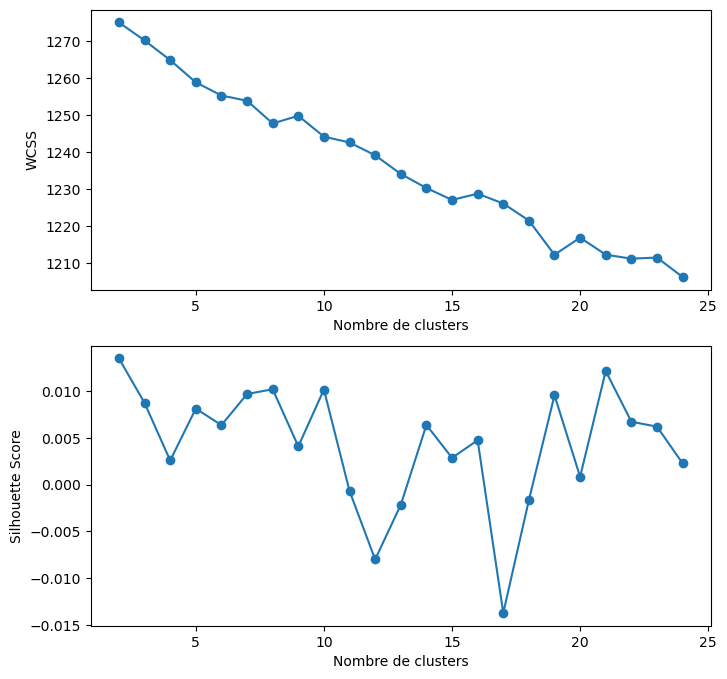

In [45]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Bi-grams

In [46]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [47]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies - classement des mots')]

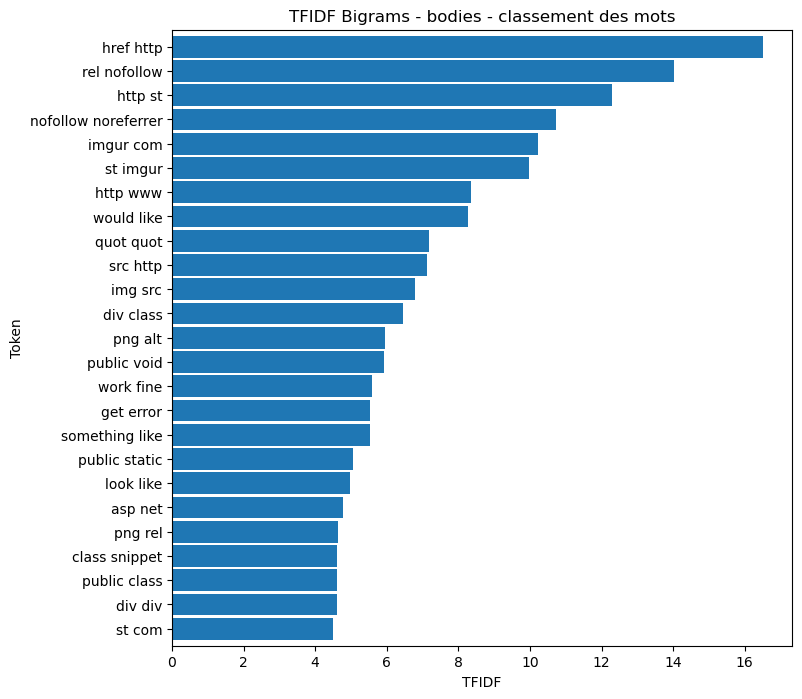

In [48]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies - classement des mots')

In [49]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - titles - classement des mots')]

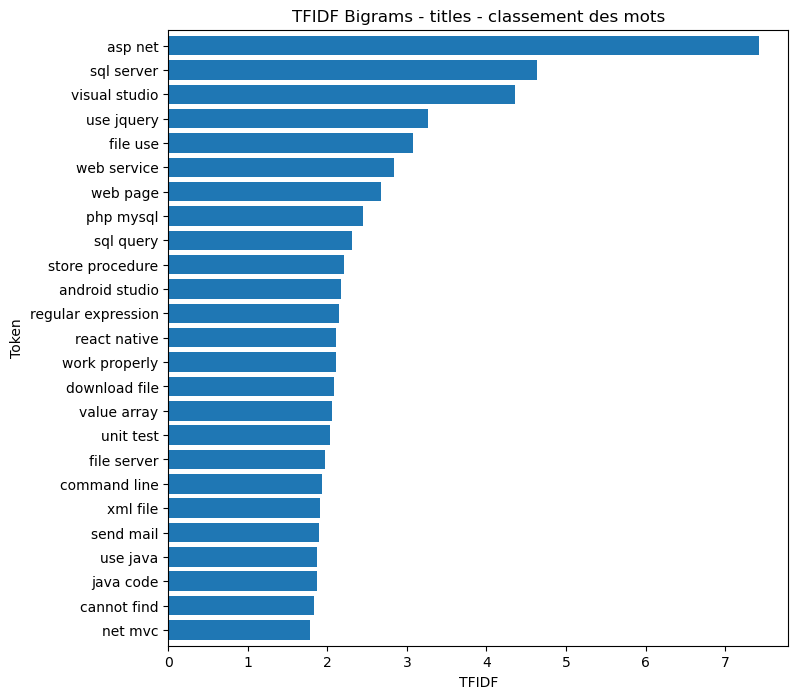

In [50]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - titles - classement des mots')

In [51]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies+titles - classement des mots')]

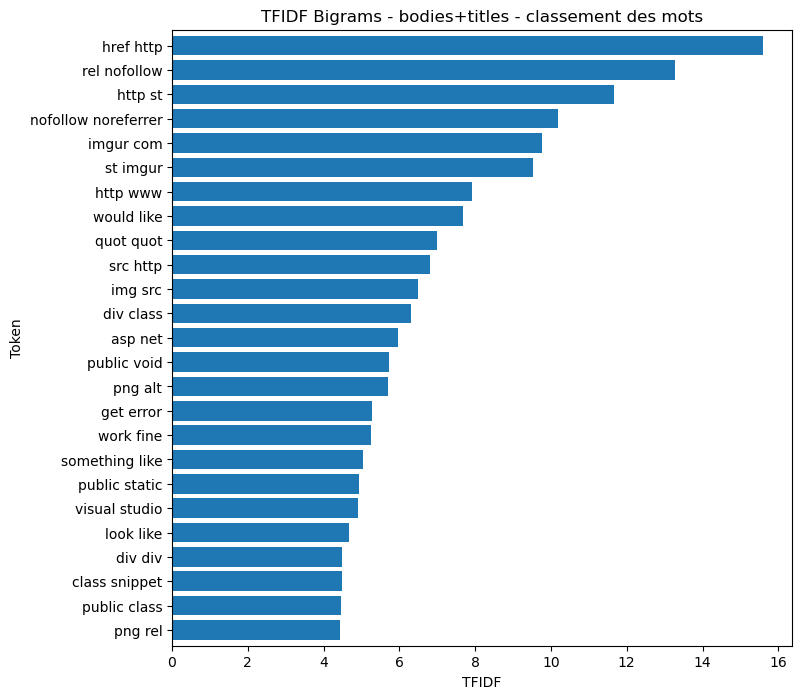

In [52]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies+titles - classement des mots')

In [53]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


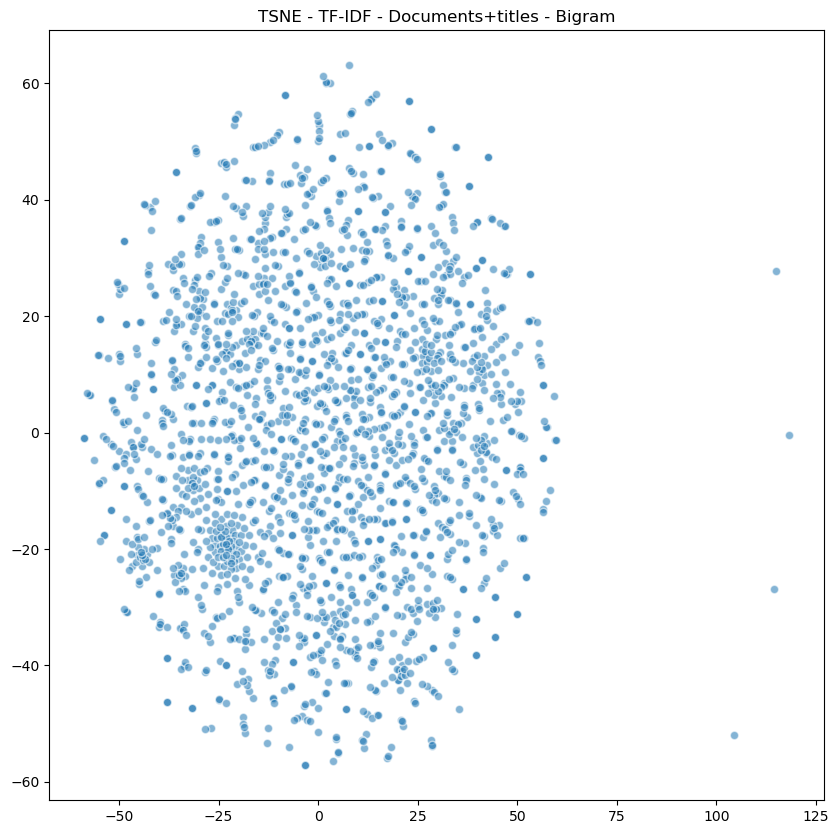

In [54]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Bigram')
plt.show()

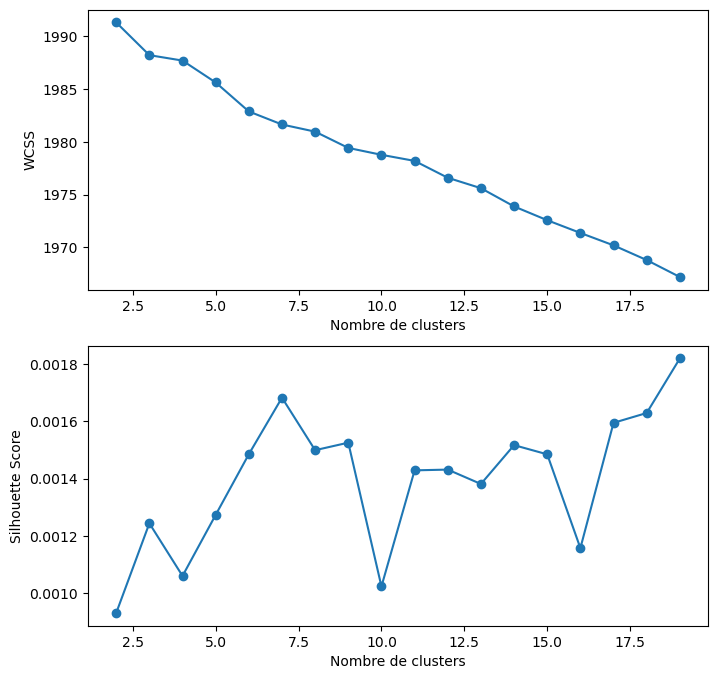

CPU times: user 2h 46min 41s, sys: 1min 43s, total: 2h 48min 25s
Wall time: 19min 22s


In [55]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
#centreReduit = preprocessing.StandardScaler().fit(X)
#XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [56]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

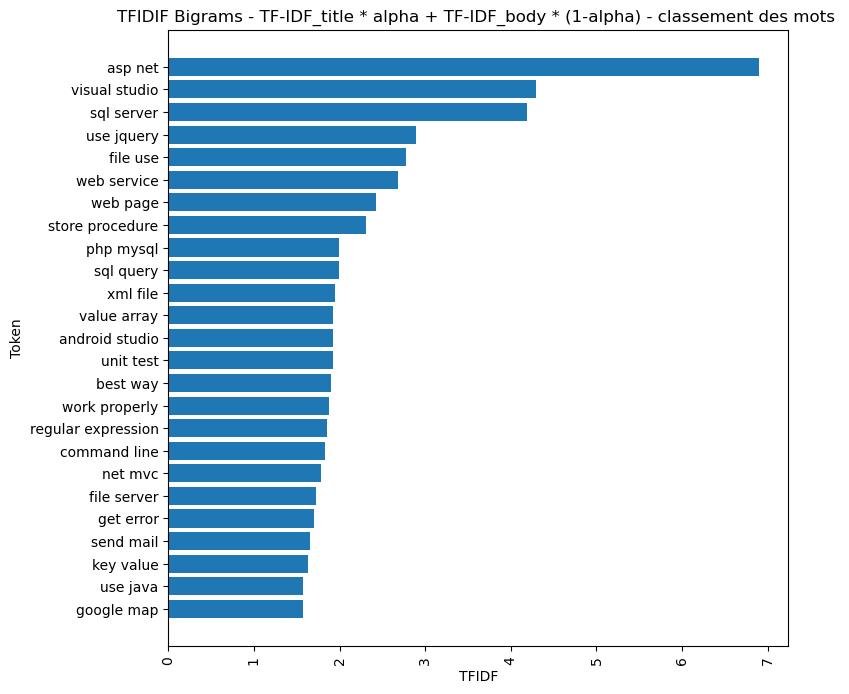

In [57]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDIF Bigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [58]:
X=dfTFIDFCommon.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


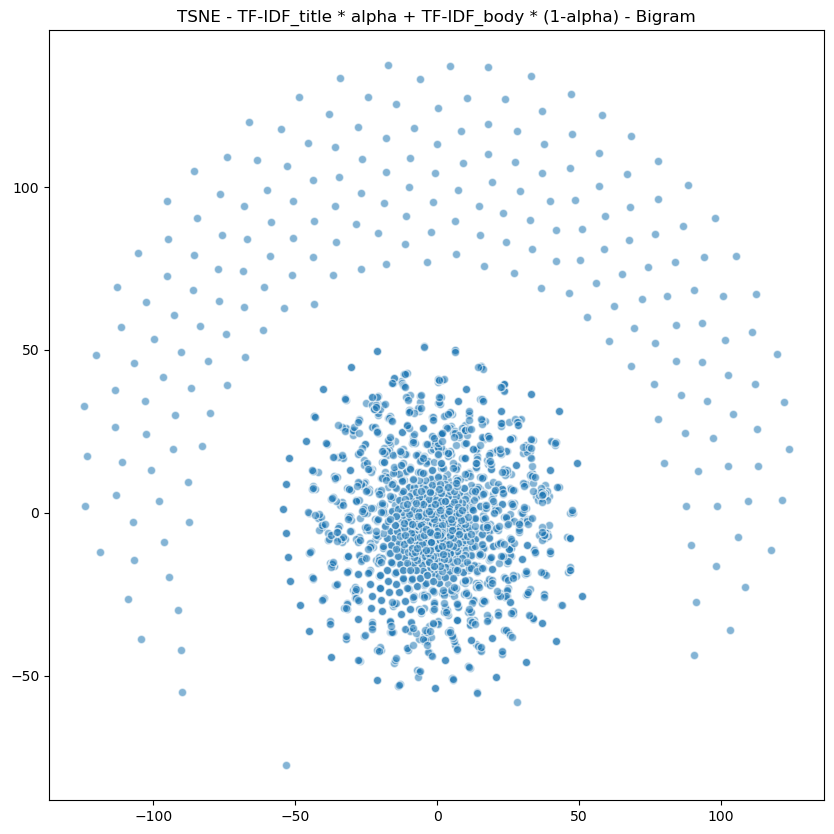

In [59]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

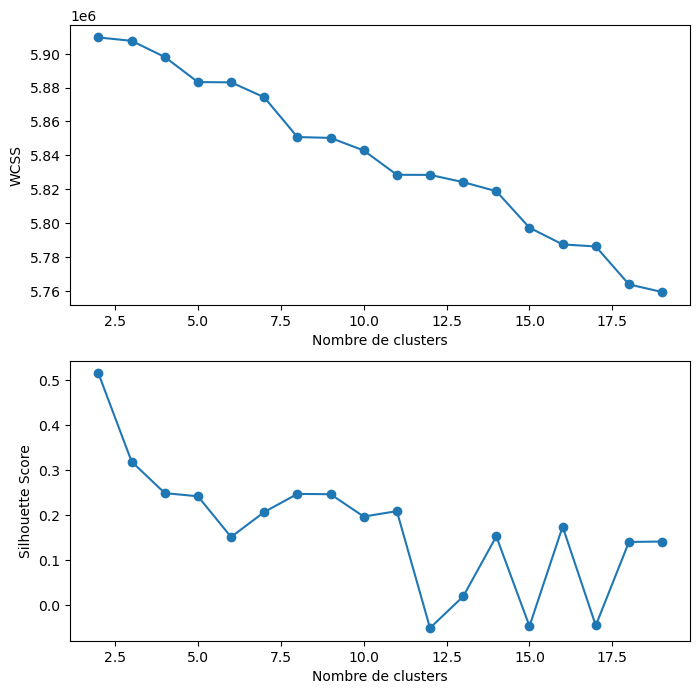

CPU times: user 2min 12s, sys: 2.75 s, total: 2min 15s
Wall time: 11.8 s


In [60]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [61]:
joblib.dump(dfTFIDFCommon,'dfTFIDFCommon.jbl.bz2')

['dfTFIDFCommon.jbl.bz2']

# Tri-grams

In [62]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 4.89 ms, sys: 13.9 ms, total: 18.8 ms
Wall time: 18.9 ms


In [63]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - bodies - classement des mots')]

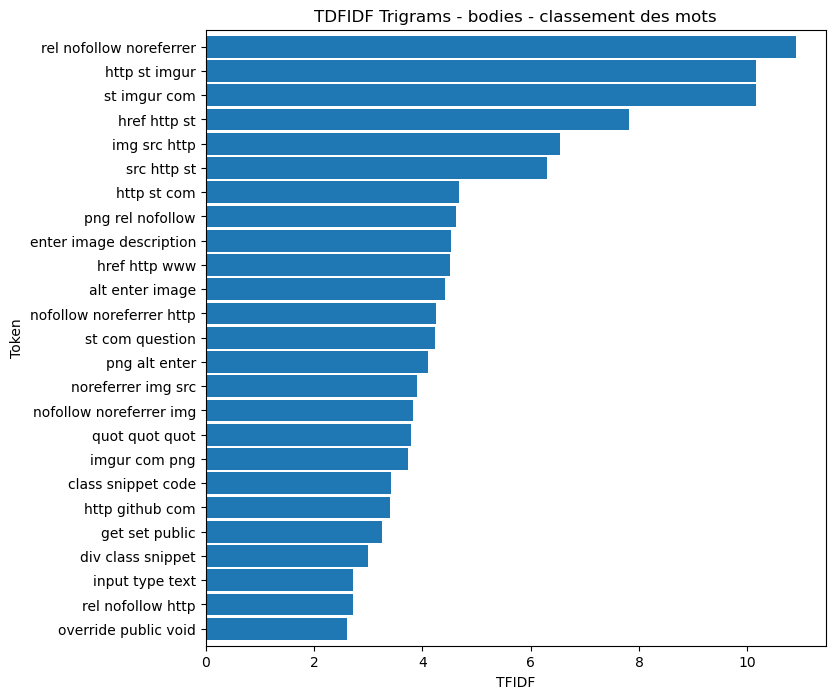

In [64]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - bodies - classement des mots')

In [65]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - classement des mots')]

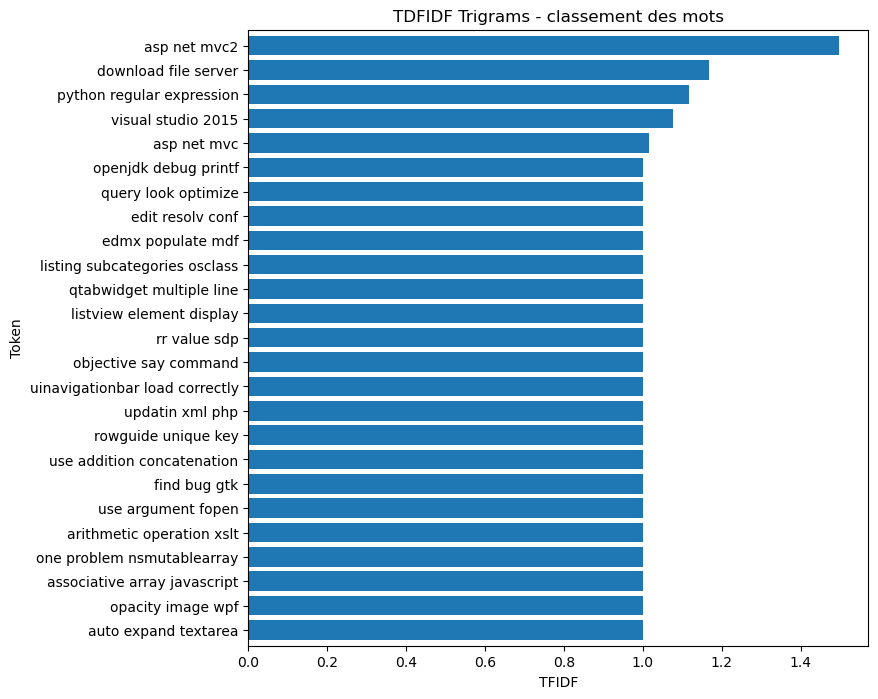

In [66]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - classement des mots')

In [67]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigram - bodies+titles - classement des mots')]

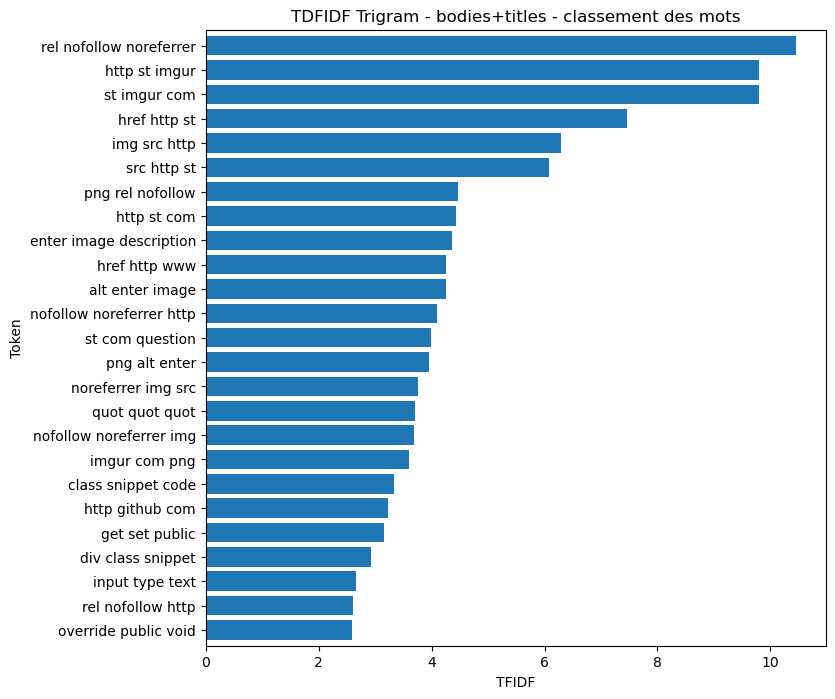

In [68]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigram - bodies+titles - classement des mots')

In [69]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


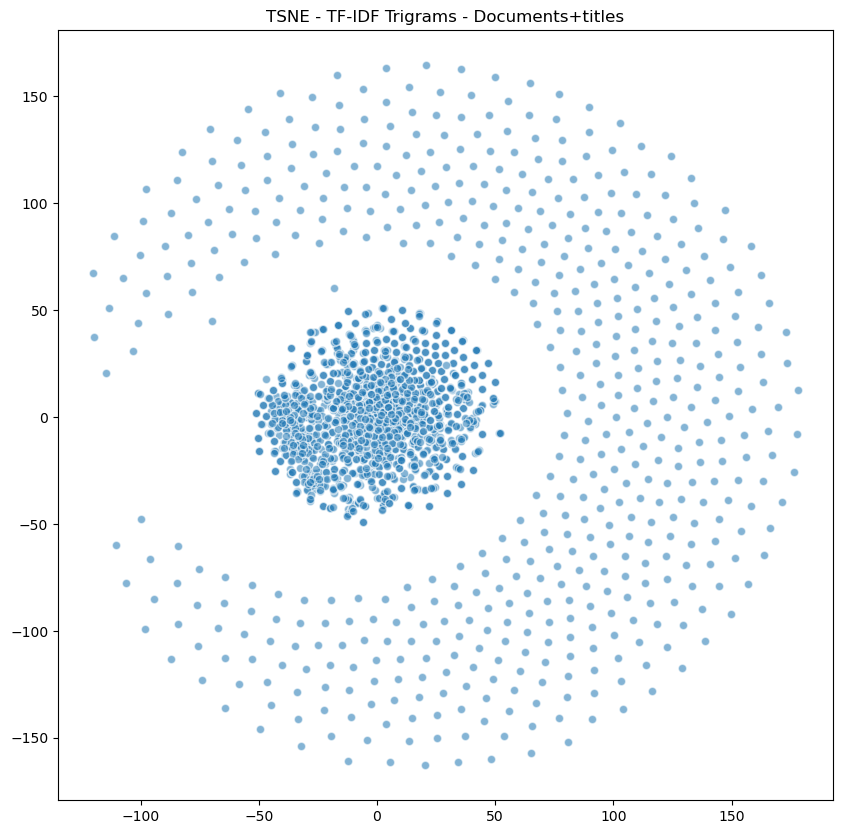

In [70]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF Trigrams - Documents+titles')
plt.show()

In [71]:
X.shape

(2000, 162819)

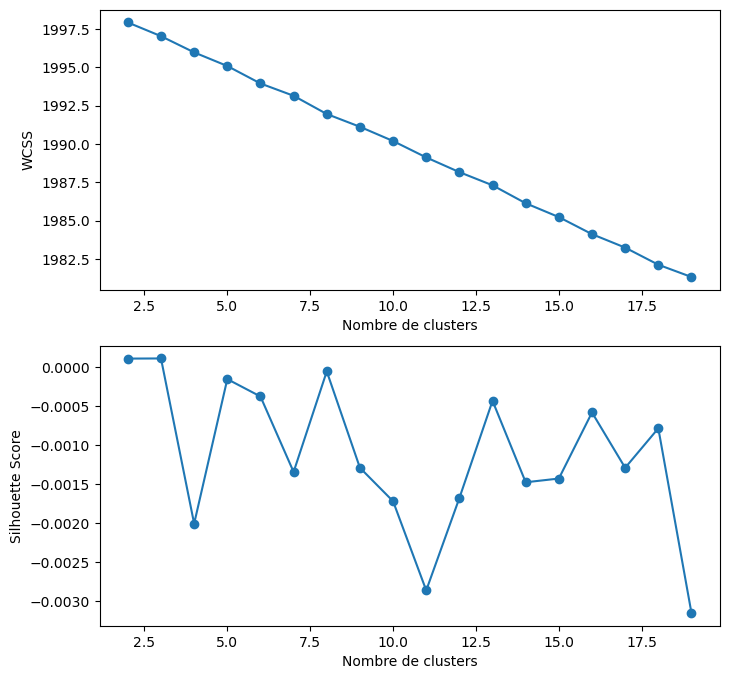

CPU times: user 30min 58s, sys: 1min 11s, total: 32min 9s
Wall time: 3min 34s


In [72]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [73]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

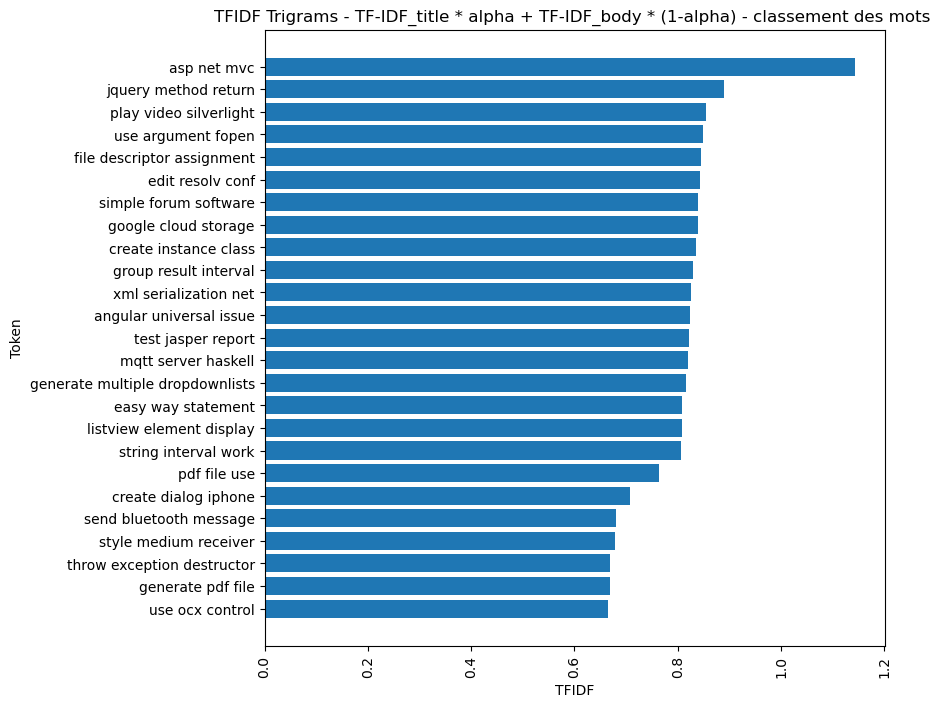

In [74]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF Trigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [75]:
X=dfTFIDFCommon

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


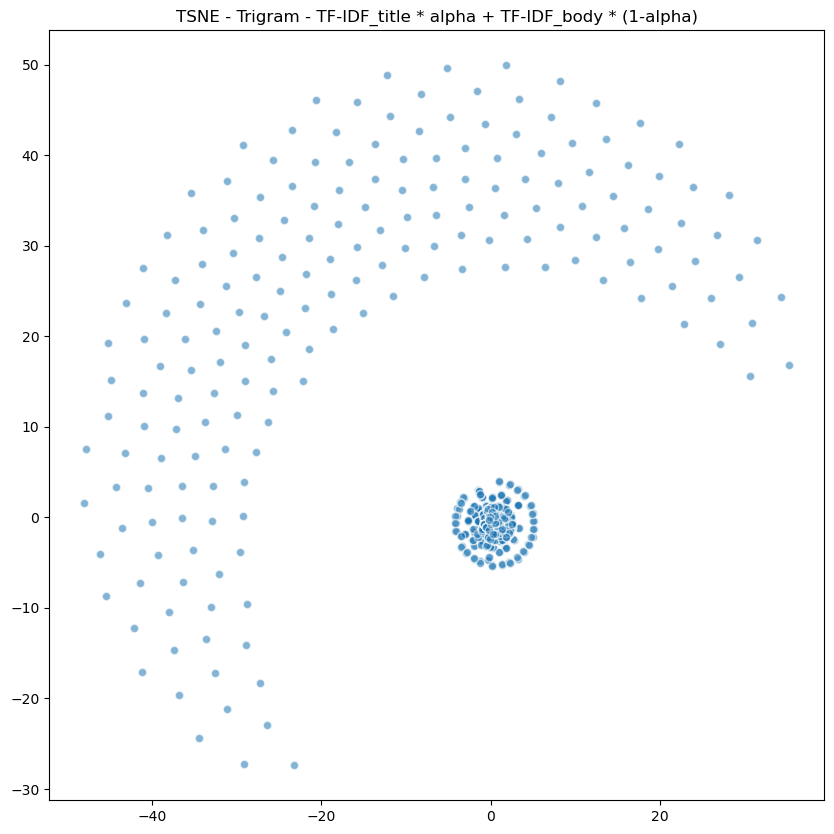

In [76]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - Trigram - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

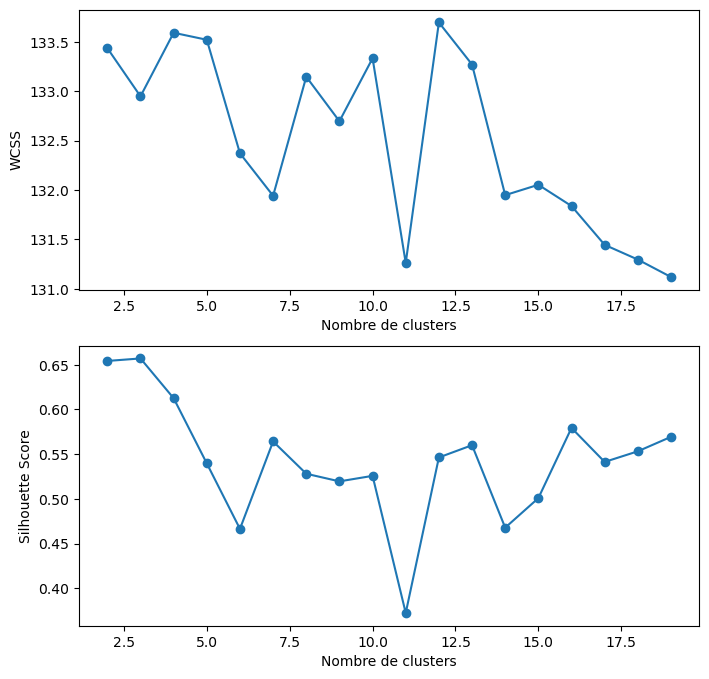

CPU times: user 24 s, sys: 747 ms, total: 24.7 s
Wall time: 2.16 s


In [77]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tags

In [78]:
tags=dfCleaned['Tags'].map(''.join)
tags

43576                                  c#  custom-controls  propertygrid  inplace-editing 
24783                                                      javascript  jquery  codemirror 
27941                                                      php  mysql  zend-search-lucene 
31045                                                                  javascript  jquery 
11525                                                 symfony  session  cookies  samesite 
35342                                                                 php  iis-7  caching 
5189                                                                angular  ng-bootstrap 
33560                                                                         c#  casting 
17916                                                                             jsf  el 
45286                                                               c#  screenshot  frame 
17193          azure-devops  azure-pipelines  azure-pipelines-tasks  azure-pipelines-yaml 

## Classement TF-IDF

In [79]:
vectorizer= TfidfVectorizer()

In [80]:
response= vectorizer.fit_transform(tags)
dfTFIDF_tags=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_tags=dfTFIDF_tags.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - tags - classement des mots')]

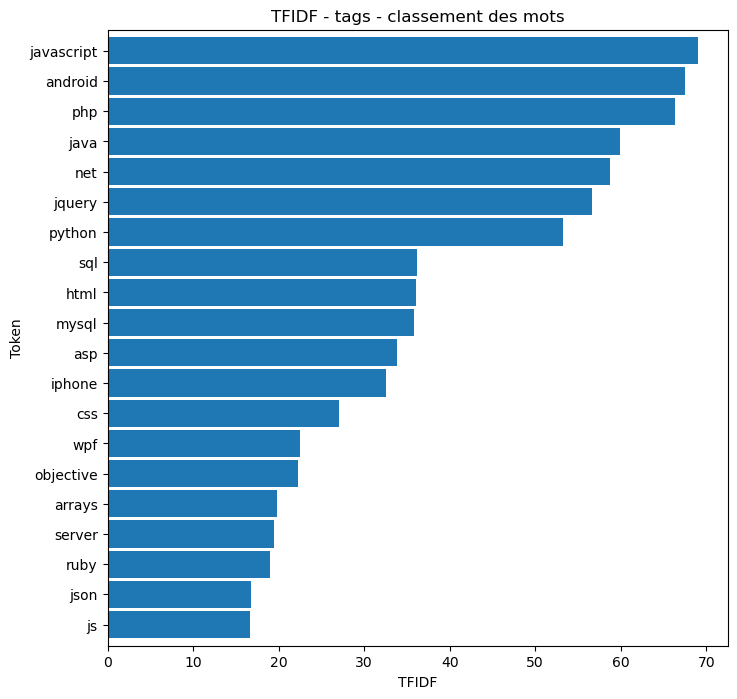

In [81]:
ax = sortedTFIDF_tags.head(20).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - tags - classement des mots')

## Labellisation

In [82]:
# correspondance Tag -> classe (0->20)
tagclass=sortedTFIDF_tags.head(20).to_dict()
for i, k in enumerate(tagclass):
    tagclass[k]=i
tagclass

{'javascript': 0,
 'android': 1,
 'php': 2,
 'java': 3,
 'net': 4,
 'jquery': 5,
 'python': 6,
 'sql': 7,
 'html': 8,
 'mysql': 9,
 'asp': 10,
 'iphone': 11,
 'css': 12,
 'wpf': 13,
 'objective': 14,
 'arrays': 15,
 'server': 16,
 'ruby': 17,
 'json': 18,
 'js': 19}

In [83]:
joblib.dump(tagclass,'tagclass.jbl.bz2')

['tagclass.jbl.bz2']

Voici les 20 tags les plus utilisés.
Que nous utiliserons comme target.

In [84]:
# filtrage des colonnes du dataset contenant les tags
cols=[]
for i,k in enumerate(tagclass):
    regexstring='.*'+k+'.*' # on recherche les chaines contenant le tag k
    cols = cols+[c for c in dfTFIDFCommon.columns if re.match(regexstring,c.lower())] # si le tag est trouvé on ajoute la colonne à notre liste de colonnes à conserver
cols=list(set(cols))

In [85]:
dfTFIDFCommonTarget=dfTFIDFCommon[cols]
dfTFIDFCommonTarget.sample(8)

,body use jquery,remove index php,give internet connection,user define python,jquery method return,server work amp,job asp net,execute statement sql,ljava lang object,image html email,launcher exception java,url use jquery,web service asp,sql statement could,type authorization net,sql constraint primary,optimize mysql query,unsigned mysql default,web service python,java util missingresourceexception,exception java lang,java lang noclassdeffounderror,javascript array array,single key json,import url jsp,asp net form,android studio create,depends version net,sql query spark,big html string,another html twig,block animation wpf,service asp net,java net urlconnection,xml serialization net,mask url php,token recognize json,java servlet use,internet connection error,javascript java servlet,...,main java lang,mqtt server haskell,java lang runtimeexception,drop list json,define unsigned mysql,asp net core,equivalent sql server,host prebid server,array convert python,server set nocount,inside another html,jquery cycle plugin,statement sql constraint,asp net mvc,top border android,printing html form,microsoft ml server,height screen android,gprs internet connection,array size python,convert sql query,pdf file json,language vbscript jscript,instance ironpython class,json file use,asp net website,array javascript java,java ee api,subnet mask rout,stingray objective toolkit,ml server client,java program try,use single mysql,search android market,pythonic way check,drivelistbox dot net,turn javascript array,use jquery ajax,php generate input,external python script
873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [86]:
# DEBUG
row=dfTFIDFCommonTarget.iloc[128]

print(getClass(row)),dfTFIDFCommonTarget.iloc[812].idxmax()

-1


(None, 'body use jquery')

In [87]:
joblib.dump(dfTFIDFCommonTarget,'dfTFIDFCommonTarget.jbl.bz2')

['dfTFIDFCommonTarget.jbl.bz2']